In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab as pl
%matplotlib inline

In [2]:
df_zip = pd.read_csv('data/data_zip.csv', dtype={'ZIPCODE': str})
df_zip_clean = pd.read_csv('data/data_zip_clean.csv', dtype={'ZIPCODE': str})

In [3]:
df_zip = df_zip[['ZIPCODE', 'POPULATION', 'HOUSEHOLD', 'AREA', 'Com_Counts', 'Com_Counts_2014', 'Vio_Counts', 
                'Vio_Counts_2014', 'com_percapita', 'com_perhousehold', 'vio_percapita', 'vio_perhousehold',
                 'com_percapita_2014', 'com_perhousehold_2014', 'vio_percapita_2014', 'vio_perhousehold_2014', 
                 'ratio(com/vio)']]
df_zip_clean = df_zip_clean[['ZIPCODE', 'POPULATION', 'HOUSEHOLD', 'AREA', 'Com_Counts', 'Com_Counts_2014', 'Vio_Counts', 
                'Vio_Counts_2014', 'com_percapita', 'com_perhousehold', 'vio_percapita', 'vio_perhousehold',
                 'com_percapita_2014', 'com_perhousehold_2014', 'vio_percapita_2014', 'vio_perhousehold_2014', 
                 'ratio(com/vio)']]

In [4]:
# Potential features from ACS data
f_elderly = pd.read_csv('data/features/elderlypop.csv', dtype={'Id2': str})
f_education = pd.read_csv('data/features/highereducation.csv', dtype={'Id2': str})
f_income = pd.read_csv('data/features/medianhouseholdincome.csv', dtype={'Id2': str, 'medianhouseholdincome': float})
f_children = pd.read_csv('data/features/householdwithchildunder6.csv', dtype={'Id2': str})
f_language = pd.read_csv('data/features/noneglishspeaker.csv', dtype={'Id2': str})

In [5]:
# Rename column 'Id2' to 'ZIPCODE'
f_elderly = f_elderly.rename(columns={'Id2': 'ZIPCODE', 'elderlypop%': 'elderly'})
f_education = f_education.rename(columns={'Id2': 'ZIPCODE', 'highereductation%': 'education'})
f_income = f_income.rename(columns={'Id2': 'ZIPCODE', 'medianhouseholdincome': 'medianincome'})
f_children = f_children.rename(columns={'Id2': 'ZIPCODE', 'householdwithchild%': 'child'})
f_language = f_language.rename(columns={'Id2': 'ZIPCODE'})

In [6]:
# Merge dataset in order to make full dataset for stats modeling
features = [f_elderly, f_education, f_income, f_children, f_language]

for f in features:
    df_zip = pd.merge(df_zip, f, how='left', on='ZIPCODE')
    print len(df_zip.columns)

for f in features:
    df_zip_clean = pd.merge(df_zip_clean, f, how='left', on='ZIPCODE')
    print len(df_zip_clean.columns)

18
19
20
21
22
18
19
20
21
22


In [7]:
df_zip.corr()

,POPULATION,HOUSEHOLD,AREA,Com_Counts,Com_Counts_2014,Vio_Counts,Vio_Counts_2014,com_percapita,com_perhousehold,vio_percapita,...,com_percapita_2014,com_perhousehold_2014,vio_percapita_2014,vio_perhousehold_2014,ratio(com/vio),elderly,education,medianincome,child,noneglishspeaker
POPULATION,1.000000,0.962236,0.464560,0.705243,0.694253,0.708980,0.611840,0.087238,0.426896,0.551963,...,0.567579,0.568402,0.435706,0.245671,-0.237324,-0.611826,-0.380499,-0.485461,-0.517464,0.405418
HOUSEHOLD,0.962236,1.000000,0.416172,0.661634,0.648676,0.656265,0.555834,0.081553,0.386451,0.527936,...,0.546276,0.517309,0.400047,0.209746,-0.211035,-0.396777,-0.165481,-0.360654,-0.514091,0.278816
AREA,0.464560,0.416172,1.000000,0.105068,0.110257,0.110218,0.074977,-0.043812,0.035133,0.108316,...,0.077919,0.130646,0.136746,0.225133,-0.016297,-0.032211,-0.300649,-0.136372,-0.245848,-0.023276
Com_Counts,0.705243,0.661634,0.105068,1.000000,0.991900,0.976955,0.973404,0.226993,0.710211,0.854809,...,0.900628,0.903309,0.800892,0.492877,-0.155913,-0.511212,-0.382420,-0.498036,-0.302361,0.293835
Com_Counts_2014,0.694253,0.648676,0.110257,0.991900,1.000000,0.969323,0.970386,0.222537,0.696048,0.837700,...,0.899775,0.902074,0.790387,0.486970,-0.152280,-0.487490,-0.385494,-0.487146,-0.293596,0.271601
Vio_Counts,0.708980,0.656265,0.110218,0.976955,0.969323,1.000000,0.973921,0.219213,0.694178,0.879664,...,0.876214,0.884550,0.802377,0.496263,-0.218711,-0.609654,-0.400556,-0.507077,-0.300729,0.307583
Vio_Counts_2014,0.611840,0.555834,0.074977,0.973404,0.970386,0.973921,1.000000,0.228697,0.704925,0.858384,...,0.883773,0.898892,0.832542,0.522422,-0.159510,-0.519455,-0.399126,-0.479383,-0.253931,0.291380
com_percapita,0.087238,0.081553,-0.043812,0.226993,0.222537,0.219213,0.228697,1.000000,0.621380,0.230667,...,0.243097,0.236150,0.220358,0.126546,-0.151035,-0.424015,0.040962,0.052016,0.429118,0.072659
com_perhousehold,0.426896,0.386451,0.035133,0.710211,0.696048,0.694178,0.704925,0.621380,1.000000,0.726576,...,0.754320,0.752668,0.677909,0.411276,-0.158322,-0.477466,-0.450080,-0.563060,-0.291074,0.314461
vio_percapita,0.551963,0.527936,0.108316,0.854809,0.837700,0.879664,0.858384,0.230667,0.726576,1.000000,...,0.947028,0.953067,0.938856,0.682251,-0.286207,-0.543905,-0.391541,-0.532565,-0.282983,0.251999


In [8]:
#df_zip.corr().to_csv('data/features/corr_result.csv')

In [9]:
df_zip_clean.corr()

,POPULATION,HOUSEHOLD,AREA,Com_Counts,Com_Counts_2014,Vio_Counts,Vio_Counts_2014,com_percapita,com_perhousehold,vio_percapita,...,com_percapita_2014,com_perhousehold_2014,vio_percapita_2014,vio_perhousehold_2014,ratio(com/vio),elderly,education,medianincome,child,noneglishspeaker
POPULATION,1.000000,0.958279,0.526502,0.786213,0.751635,0.783929,0.677936,0.563018,0.614833,0.574911,...,0.555974,0.602439,0.486075,0.518616,-0.244873,-0.612771,-0.322844,-0.431374,-0.546863,0.418569
HOUSEHOLD,0.958279,1.000000,0.463212,0.769350,0.730023,0.749571,0.645823,0.585243,0.584159,0.584161,...,0.567793,0.566798,0.481978,0.477980,-0.218789,-0.390972,-0.090006,-0.298436,-0.537638,0.287835
AREA,0.526502,0.463212,1.000000,0.196075,0.199552,0.203760,0.168815,0.112588,0.164441,0.122279,...,0.124672,0.173490,0.101938,0.137643,0.001631,-0.077704,-0.327944,-0.164359,-0.271374,0.020328
Com_Counts,0.786213,0.769350,0.196075,1.000000,0.976963,0.945730,0.947876,0.834518,0.868269,0.799511,...,0.834013,0.861247,0.798660,0.813449,-0.166613,-0.464191,-0.259311,-0.457109,-0.382214,0.207626
Com_Counts_2014,0.751635,0.730023,0.199552,0.976963,1.000000,0.920210,0.951077,0.804311,0.840959,0.769542,...,0.850355,0.878964,0.797391,0.813732,-0.157089,-0.405971,-0.270857,-0.436729,-0.359673,0.190824
Vio_Counts,0.783929,0.749571,0.203760,0.945730,0.920210,1.000000,0.941620,0.773187,0.816866,0.844681,...,0.772173,0.808527,0.785162,0.809065,-0.268920,-0.609677,-0.279873,-0.457966,-0.369642,0.246014
Vio_Counts_2014,0.677936,0.645823,0.168815,0.947876,0.951077,0.941620,1.000000,0.793623,0.837939,0.804474,...,0.821987,0.858830,0.863119,0.887275,-0.179115,-0.479963,-0.302019,-0.449059,-0.316941,0.154294
com_percapita,0.563018,0.585243,0.112588,0.834518,0.804311,0.773187,0.793623,1.000000,0.970338,0.933411,...,0.969854,0.938424,0.929982,0.893286,-0.144420,-0.317700,-0.198494,-0.458676,-0.310377,0.060650
com_perhousehold,0.614833,0.584159,0.164441,0.868269,0.840959,0.816866,0.837939,0.970338,1.000000,0.917308,...,0.950435,0.972181,0.926027,0.932967,-0.161032,-0.415751,-0.377648,-0.555613,-0.357622,0.148359
vio_percapita,0.574911,0.584161,0.122279,0.799511,0.769542,0.844681,0.804474,0.933411,0.917308,1.000000,...,0.910546,0.890832,0.922681,0.896580,-0.324579,-0.520334,-0.213155,-0.458507,-0.307250,0.104427


In [10]:
#df_zip_clean.corr().to_csv('data/features/corr_result_clean.csv')

In [11]:
df_zip_clean.describe()

/Users/bh1555/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,POPULATION,HOUSEHOLD,AREA,Com_Counts,Com_Counts_2014,Vio_Counts,Vio_Counts_2014,com_percapita,com_perhousehold,vio_percapita,...,com_percapita_2014,com_perhousehold_2014,vio_percapita_2014,vio_perhousehold_2014,ratio(com/vio),elderly,education,medianincome,child,noneglishspeaker
count,234.000000,234.000000,2.340000e+02,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,...,234.000000,234.000000,234.000000,234.000000,166.000000,56.000000,169.000000,168.000000,167.000000,169.000000
mean,28959.188034,11309.069636,3.133819e+07,1468.910256,1450.957265,1290.247863,544.128205,0.031272,0.079640,0.026857,...,0.030627,0.078483,0.011100,0.028878,inf,0.149257,41.655621,70187.005952,0.003412,42.326627
std,28720.787841,10861.015053,4.571040e+07,2046.570318,2138.050114,1852.214598,917.343660,0.034984,0.089950,0.031171,...,0.035474,0.091911,0.016019,0.042085,NaN,0.041666,22.126409,32989.635937,0.005175,18.890617
min,1.000000,1.000000,3.154825e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.400297,0.078115,9.100000,19536.000000,0.000504,0.000000
25%,1.000000,2.000000,5.110091e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,25060.500000,9548.500000,1.884162e+07,472.500000,588.000000,433.500000,141.500000,0.022584,0.053382,0.016596,...,0.022057,0.053341,0.006072,0.013797,NaN,NaN,NaN,NaN,NaN,NaN
75%,44174.500000,18304.250000,4.766802e+07,2111.750000,2032.750000,1756.500000,666.000000,0.045698,0.120769,0.042944,...,0.044557,0.120949,0.013732,0.036873,NaN,NaN,NaN,NaN,NaN,NaN
max,109070.000000,43609.000000,4.739857e+08,11018.000000,11993.000000,10005.000000,6672.000000,0.192171,0.427560,0.152839,...,0.196026,0.436137,0.097377,0.217499,inf,0.274824,100.000000,250000.000000,0.042527,88.200000


In [12]:
df_zip_clean['ratio(com/vio)'] = df_zip_clean['ratio(com/vio)'].replace(np.inf, np.nan)

In [13]:
df_zip_clean.describe()

,POPULATION,HOUSEHOLD,AREA,Com_Counts,Com_Counts_2014,Vio_Counts,Vio_Counts_2014,com_percapita,com_perhousehold,vio_percapita,...,com_percapita_2014,com_perhousehold_2014,vio_percapita_2014,vio_perhousehold_2014,ratio(com/vio),elderly,education,medianincome,child,noneglishspeaker
count,234.000000,234.000000,2.340000e+02,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,...,234.000000,234.000000,234.000000,234.000000,165.000000,56.000000,169.000000,168.000000,167.000000,169.000000
mean,28959.188034,11309.069636,3.133819e+07,1468.910256,1450.957265,1290.247863,544.128205,0.031272,0.079640,0.026857,...,0.030627,0.078483,0.011100,0.028878,1.410340,0.149257,41.655621,70187.005952,0.003412,42.326627
std,28720.787841,10861.015053,4.571040e+07,2046.570318,2138.050114,1852.214598,917.343660,0.034984,0.089950,0.031171,...,0.035474,0.091911,0.016019,0.042085,0.944884,0.041666,22.126409,32989.635937,0.005175,18.890617
min,1.000000,1.000000,3.154825e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.400297,0.078115,9.100000,19536.000000,0.000504,0.000000
25%,1.000000,2.000000,5.110091e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,25060.500000,9548.500000,1.884162e+07,472.500000,588.000000,433.500000,141.500000,0.022584,0.053382,0.016596,...,0.022057,0.053341,0.006072,0.013797,NaN,NaN,NaN,NaN,NaN,NaN
75%,44174.500000,18304.250000,4.766802e+07,2111.750000,2032.750000,1756.500000,666.000000,0.045698,0.120769,0.042944,...,0.044557,0.120949,0.013732,0.036873,NaN,NaN,NaN,NaN,NaN,NaN
max,109070.000000,43609.000000,4.739857e+08,11018.000000,11993.000000,10005.000000,6672.000000,0.192171,0.427560,0.152839,...,0.196026,0.436137,0.097377,0.217499,8.555556,0.274824,100.000000,250000.000000,0.042527,88.200000


In [14]:
columns = df_zip_clean.columns.tolist()
columns = columns[1:]
print columns

['POPULATION', 'HOUSEHOLD', 'AREA', 'Com_Counts', 'Com_Counts_2014', 'Vio_Counts', 'Vio_Counts_2014', 'com_percapita', 'com_perhousehold', 'vio_percapita', 'vio_perhousehold', 'com_percapita_2014', 'com_perhousehold_2014', 'vio_percapita_2014', 'vio_perhousehold_2014', 'ratio(com/vio)', 'elderly', 'education', 'medianincome', 'child', 'noneglishspeaker']


POPULATION
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


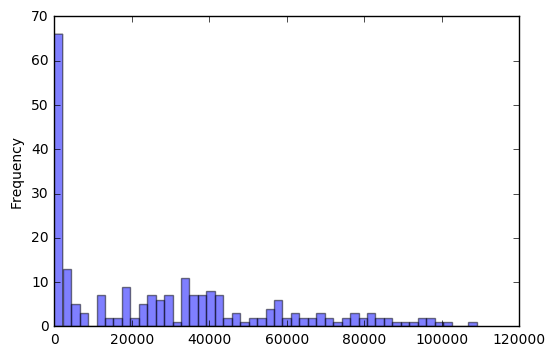

HOUSEHOLD
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


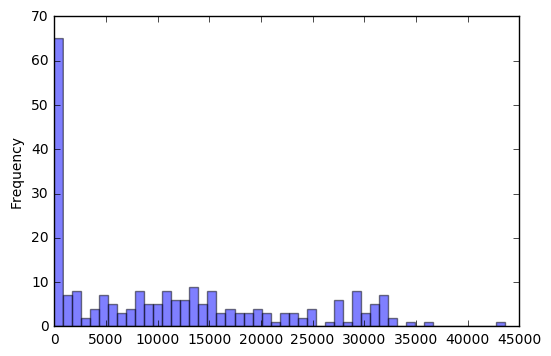

AREA
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


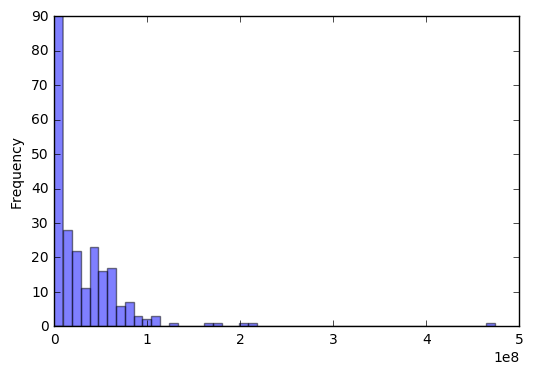

Com_Counts
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


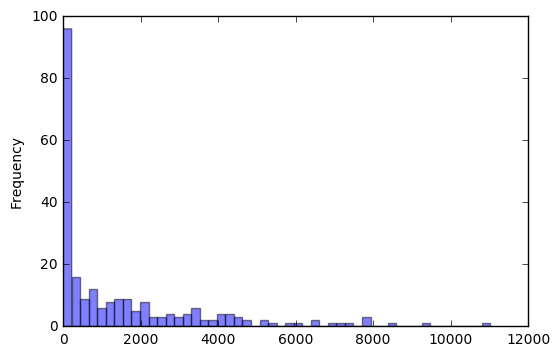

Com_Counts_2014
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


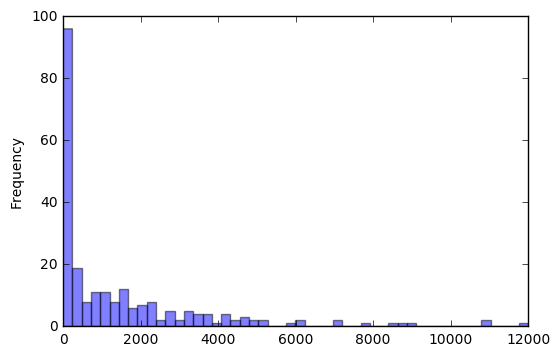

Vio_Counts
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


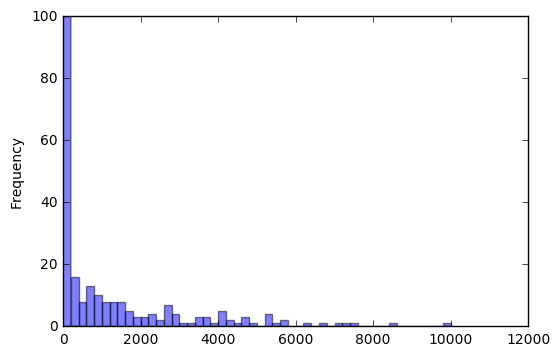

Vio_Counts_2014
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


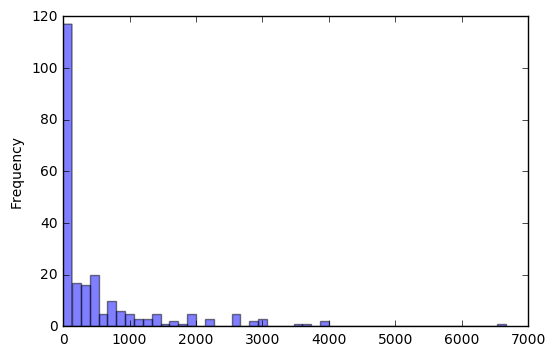

com_percapita
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


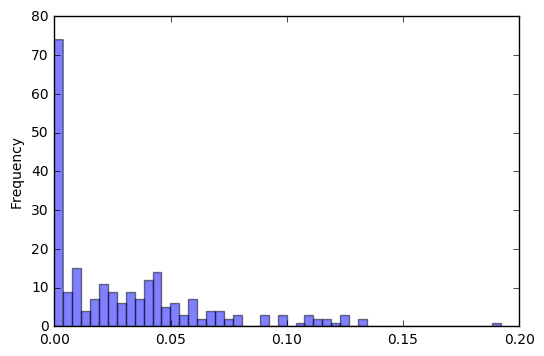

com_perhousehold
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


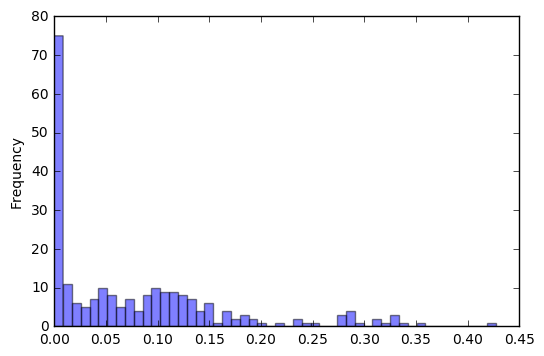

vio_percapita
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


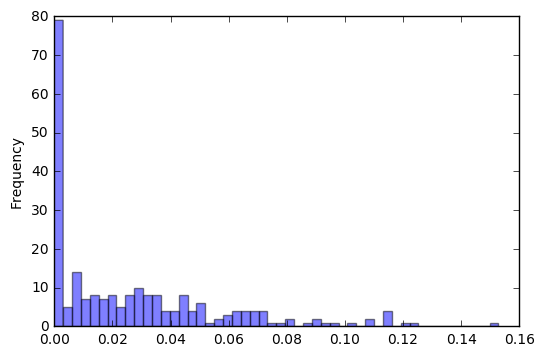

vio_perhousehold
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


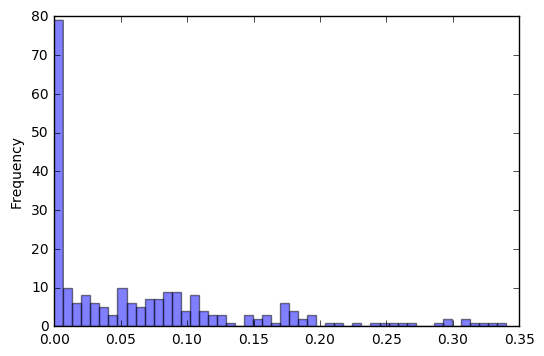

com_percapita_2014
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


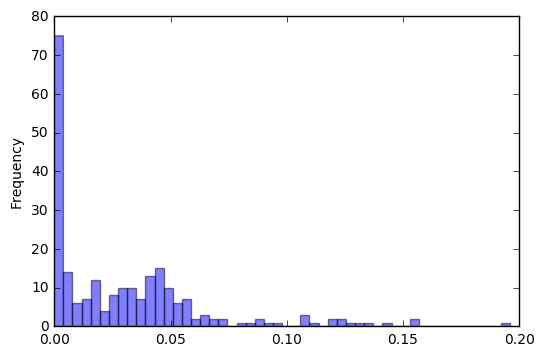

com_perhousehold_2014
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


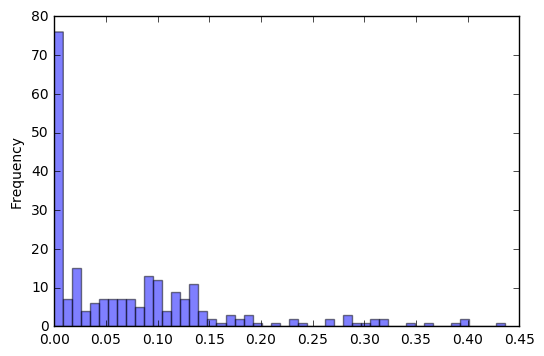

vio_percapita_2014
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


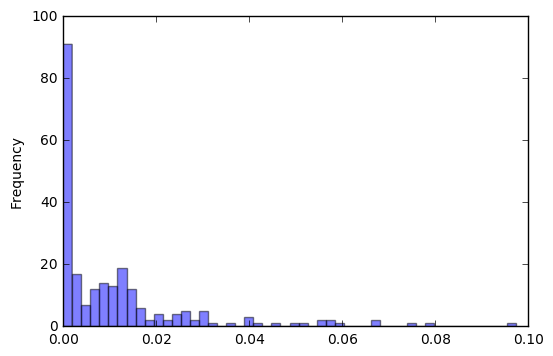

vio_perhousehold_2014
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


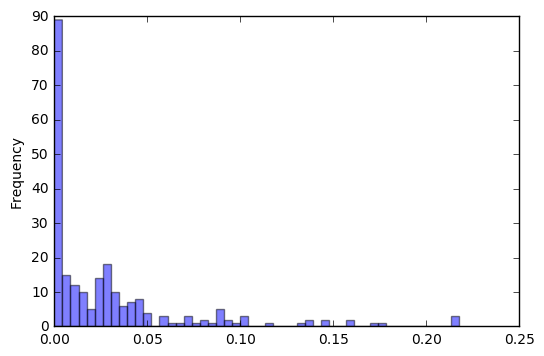

ratio(com/vio)
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


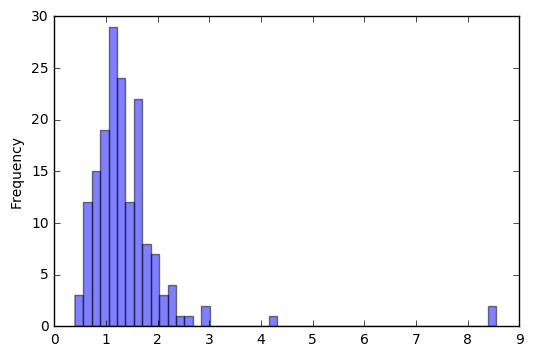

elderly
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


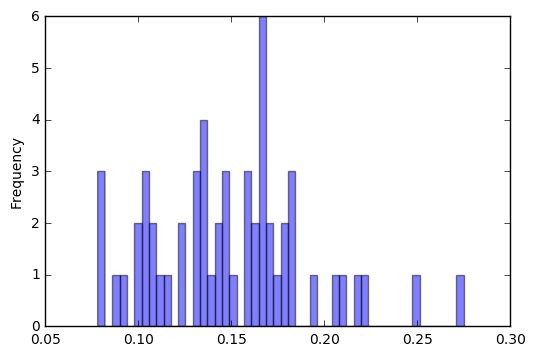

education
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


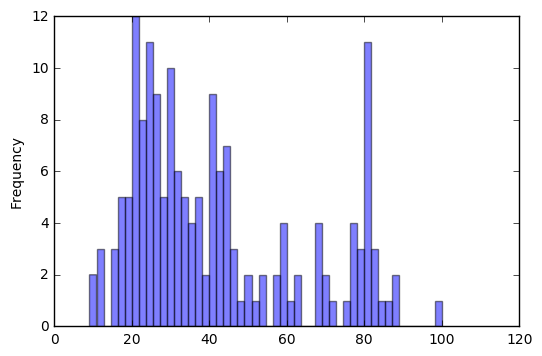

medianincome
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


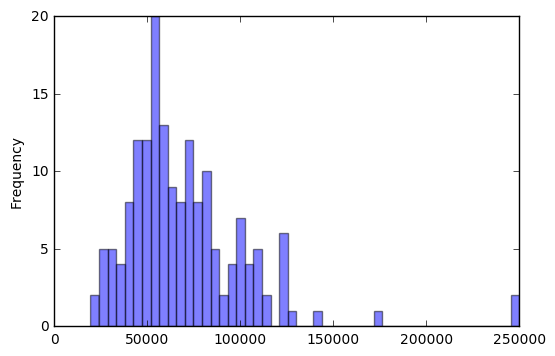

child
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


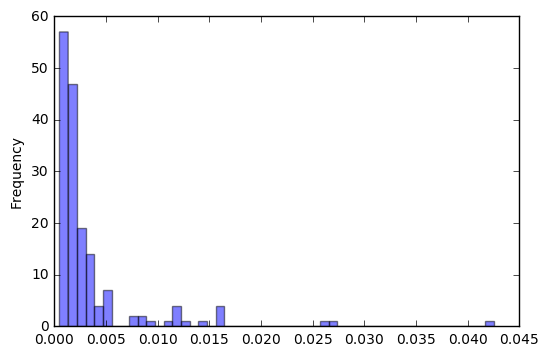

noneglishspeaker
Min:  0.0
Mean:  2406.68821293
Std:  3742.65708591
Max:  20900.0


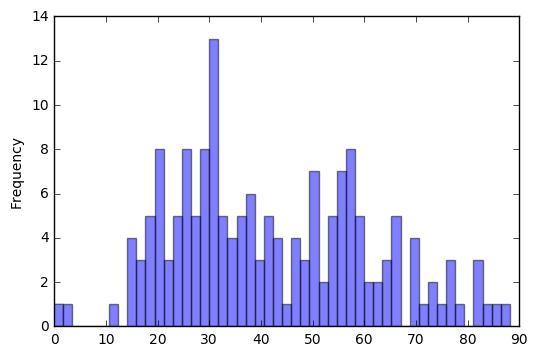

In [15]:
# distribution of variables

for c in columns:
    print c
    
    print 'Min: ', min(df_zip['Com_Counts'])
    print 'Mean: ', df_zip['Com_Counts'].mean()
    print 'Std: ', df_zip['Com_Counts'].std()
    print 'Max: ', max(df_zip['Com_Counts'])
    
    df_zip_clean[c].plot.hist(bins=50, alpha = 0.5)
    plt.show()

# Regression modeling
* modeling with raw data
    * In order to build robust model, do back and forth
    
* modeling with log format data --> unavailable due to '0' value

In [16]:
import statsmodels.formula.api as sm

In [17]:
result = sm.ols(formula="com_perhousehold ~ com_perhousehold_2014 + vio_perhousehold_2014 + elderly + education + medianincome + child + noneglishspeaker",
               data=df_zip_clean).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       com_perhousehold   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     118.4
Date:                Mon, 05 Dec 2016   Prob (F-statistic):           4.62e-28
Time:                        16:57:57   Log-Likelihood:                 140.17
No. Observations:                  56   AIC:                            -264.3
Df Residuals:                      48   BIC:                            -248.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 0.0960      0.030      3.151      0.003         0.035     0.157
com_perhousehold_2014     0.5553      0.077      7.256      0.000         0.401     0.709
vio_perhousehold_2014     0.4881      0.197      2.479      0.017         0.092     0.884
elderly                  -0.1977      0.104     -1.892      0.065        -0.408     0.012
education                 0.0009      0.000      3.169      0.003         0.000     0.001
medianincome          -1.143e-06   3.19e-07     -3.587      0.001     -1.78e-06 -5.02e-07
child                    18.5612      9.957      1.864      0.068        -1.460    38.582
noneglishspeaker         -0.0003      0.000     -1.221      0.228        -0.001     0.000
==============================================================================
Omnibus:                        6.491   Durbin-Watson:                   2.290
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                5.629
Skew:                           0.746   Prob(JB):                       0.0599
Kurtosis:                       3.434   Cond. No.                     2.23e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
result = sm.ols(formula="com_perhousehold ~ com_perhousehold_2014 + vio_perhousehold_2014 + education + medianincome ",
               data=df_zip_clean).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       com_perhousehold   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     572.3
Date:                Mon, 05 Dec 2016   Prob (F-statistic):           8.51e-95
Time:                        16:57:57   Log-Likelihood:                 396.89
No. Observations:                 168   AIC:                            -783.8
Df Residuals:                     163   BIC:                            -768.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 0.0243      0.007      3.712      0.000         0.011     0.037
com_perhousehold_2014     0.7054      0.057     12.395      0.000         0.593     0.818
vio_perhousehold_2014     0.4186      0.115      3.651      0.000         0.192     0.645
education                 0.0004      0.000      2.702      0.008      9.57e-05     0.001
medianincome          -3.175e-07   9.49e-08     -3.346      0.001     -5.05e-07  -1.3e-07
==============================================================================
Omnibus:                       20.768   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.397
Skew:                           0.696   Prob(JB):                     2.51e-07
Kurtosis:                       4.551   Cond. No.                     5.48e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.48e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""